In [1]:
from helpers import *
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.stats as stats

pd.set_option('display.max_columns', None)

In [2]:
save_dir = ''
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

In [3]:
precomputed_dir = 'precomputed_data/'

List of dataframes (one discharge per each element of the list)

In [4]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Analysis - ending insights and necessary values
For this project we are only focusing on the machine inputs provided in the data.

In [5]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [6]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
X.shape

(55005, 19)

### Key takaways :
**data is continuous** : As such we can expect Clustering Algorithms like DBSCAN to work well

**UMAP is ideal** : It allows dimensionality reduction while maintaining clusters 

**need for shot history** : we interested is how and how long it took for a shot to reach a certain point




# Clustering

## DBSCAN

### Generate a range of values for eps 

Hyperparameter tuning is essential

We need to choose the MinPts (the min number of points per cluster), and eps the radius for neighborhood computation.

MinPts: 
In practice, a general rule of thumb is that the min cluster size is equal to 2 * #features; however it can be higher for noisy data.

eps:
The value for epsilon can be chosen using a k-distance graph, which consists in plotting the distance to the k = minPts-1 nearest neighbors (ordered)
Good values of ε are where this plot shows an "elbow"
Another way to select the epsilon is to use the silouhette score, this is what we are doing here:

In [7]:
num_features = len(column_names)
eps_values = np.linspace(0.1, 4.0, 10) #DBSCAN takes much more time for higher eps
min_pts = 2 * num_features

In [8]:
# Initialize variables to store results
best_eps = None
best_silhouette_score = -1  # Initialize with a value less than any possible silhouette score


Computing the silhouette score is quite expensive as it involves the computation of the euclidean distance between all pairs in X. (~360 min)
Also note that DBSCAN time complexity increases very quickly as eps increases.

A possible solution is to only compute this matrix once; however, if X has N samples then the distance matrix has N^2 samples which is too large for N >= 50 000

Since we have 60 shots, taking half of them is representative enough for our dataset and reduces overfitting. (would take ~90 min) but how to select a shot ?

Another solution would be to iterate through range of L shots (L per L) and then aggregate the silhouette value per epsilon to find the optimal epsilon according to the aggregated values.
This approach allow for speed efficiency, all shots consideration and avoids overfitting.

we select `L=10` as a range to enable fast computation yet generalized enough.


A custom made technique :
## L-fold Hyperparameter tuning

In [9]:
L = 10
N_SHOTS = 60
# the training data fetched is already standardized.
X_standardized_list = [
    get_training_data(
        include_time=False,
        include_shotnumber=False,
        shot_indices=list(range(i * L , i * L  + L))
    )[0] for i in range(N_SHOTS // L)
]


In [10]:
X_standardized_list[0].shape

(108670, 19)

In [11]:
# Initialize matrix to store silhouette scores
silhouette_scores = np.zeros((N_SHOTS//L,len(eps_values)))
silhouette_scores.shape

(6, 10)

In [12]:
# For simplicity of running the jupyter quickly, try loading precomputed desired silhouette scores.

try:
    with open(f"{precomputed_dir}silhouette_scores_for_{L}_per_{L}.pkl", 'rb') as f:
        silhouette_scores = pkl.load(f)
# If the desired silhouette scores does not exist, compute it.
except:
    dbscan = DBSCAN()
    # Loop over different combinations of eps and min_samples
    for j, X_standardized in tqdm(enumerate(X_standardized_list), total=N_SHOTS // L):
        for i, eps in tqdm(enumerate(eps_values), total=len(eps_values)):
            # Fit DBSCAN with current parameters
            start = datetime.now()
            dbscan = dbscan.set_params(eps=eps, min_samples=min_pts)# DBSCAN(eps=eps, min_samples=min_pts)
            labels = dbscan.fit_predict(X_standardized)
            print("DBSCAN ", datetime.now()-start)
            
            # Calculate silhouette score
            start = datetime.now()
            try:
                silhouette = silhouette_score(X_standardized, labels)
            except:
                silhouette = 0
            print("Silhouette ", datetime.now()-start)
            silhouette_scores[j, i] = silhouette  
            # Store the silhouette score
                
            # Update the best parameters if the silhouette score is higher
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_min_pts = min_pts
                best_eps = eps
        
    # Print the best parameters
    print(f"Best eps: {best_eps}")
    print(f"Best silhouette score: {best_silhouette_score}")
    with open(f'{precomputed_dir}silhouette_scores_for{L}_per_{L}.pkl', 'wb') as f:
        pkl.dump(silhouette_scores, f)


In [13]:
aggregated_silhouette_scores_mean = np.mean(silhouette_scores, axis=0)
aggregated_silhouette_scores_median = np.median(silhouette_scores, axis=0)
aggregated_silhouette_scores_median.shape

(10,)

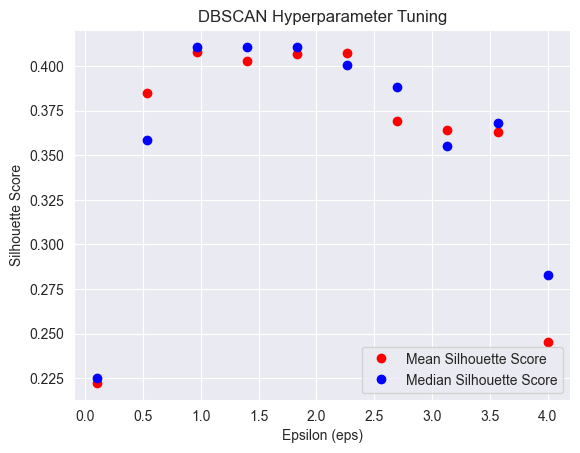

In [14]:
plt.plot(eps_values, aggregated_silhouette_scores_mean, "ro", label="Mean Silhouette Score")
plt.plot(eps_values, aggregated_silhouette_scores_median, "bo", label="Median Silhouette Score")
plt.title(f"DBSCAN Hyperparameter Tuning")
plt.xlabel("Epsilon (eps)")
plt.ylabel("Silhouette Score")
plt.legend()


In [15]:
best_mean_eps = eps_values[np.argmax(aggregated_silhouette_scores_mean)]
best_median_eps = eps_values[np.argmax(aggregated_silhouette_scores_median)]
print("best mean eps :", best_mean_eps)
print("best median eps :", best_median_eps)

best mean eps : 0.9666666666666667
best median eps : 0.9666666666666667


Ideally, we want an epsilon that yields the highest silhouette score; however, we want epsilon to be small too. So here we take the smallest epsilon which yields a high silhouette score. Here we are lucky ! since both highest silhouette with the smallest epsilon is the same, furthermore the median and mean are in accordance here. 

Theoretically everything says that we should take `eps = 0.966`.

Upon running the next cells with this epsilon value we get the expected results of similar paths.


In [16]:
selected_eps = 0.96
selected_min_pts = num_features * 2 

Let's now compute DBSCAN for 5 shots :

In [17]:
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(X)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 0


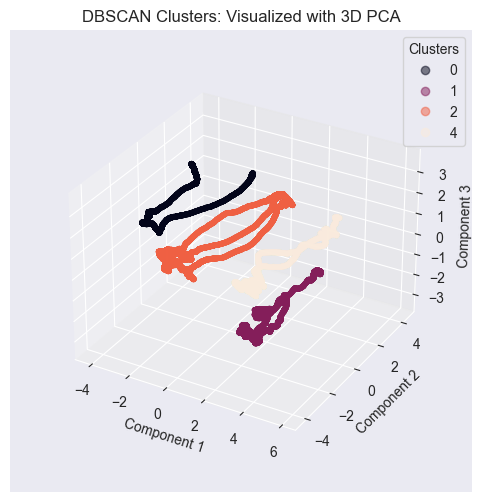

In [18]:
pca = PCA()
X_pca = pca.fit_transform(X)
draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = [0,1,2, 4, 5], legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D PCA")

## Analysis

Thanks to the silhouette score computation, we can say that the aggregated optimal epsilon `eps` for DBscan is theoretically `0.966`
Through these computations, we can therefore compute better DBSCAN on our data.
The above visualization and the one in the first analysis, displayed that similar shots could be regrouped and conversely separated from different ones.

This separation could allow us to regroup similar shots for further and closer inspection.

In order to enhance these agglomerations in clusters.


## DBSCAN
Using the optimal values yielded by the L-fold above, we can now use the DBSCAN on the hole data set.

Let's now retrieve the entire dataset :

In [19]:
complete_X, complete_y, _  = get_training_data(include_time=False, 
                                           include_shotnumber=False,
                                           shot_indices=list(range(60))
                                           )

In [20]:
label_filename = f'{precomputed_dir}labels_dbscan_eps_{selected_eps}_min_pts_{selected_min_pts}_2.pkl'
dbscan_fitted_filename = f'{precomputed_dir}fit_dbscan_eps_{selected_eps}_min_pts_{selected_min_pts}_2.pkl'

try:
    with open(label_filename, 'rb') as f:
        labels = pkl.load(f)
    with open(dbscan_fitted_filename, 'rb') as f:
        dbscan = pkl.load(f)
except:
    dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(complete_X)
    labels = dbscan.labels_
    with open(label_filename, 'wb') as f:
        pkl.dump(labels,f)
    with open(dbscan_fitted_filename, 'wb') as f:
        pkl.dump(dbscan,f)

In [21]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 29
Estimated number of noise points: 0


**Let's now visualize what the DBSCAN gave us using PCA**

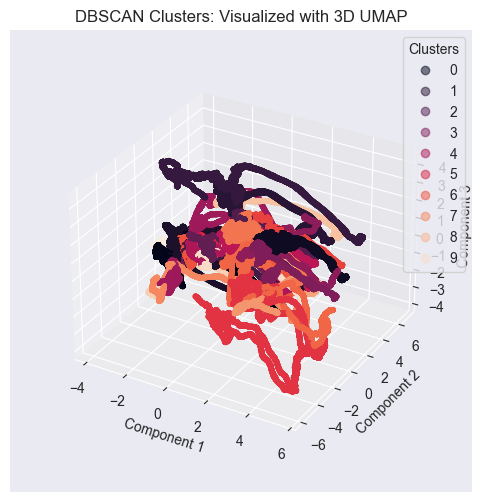

In [22]:
pca = PCA()
X_pca = pca.fit_transform(complete_X)

draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = range(n_clusters_), legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D UMAP")

The graph seems unclear, in order to evaluate it let's look at each cluster separately:

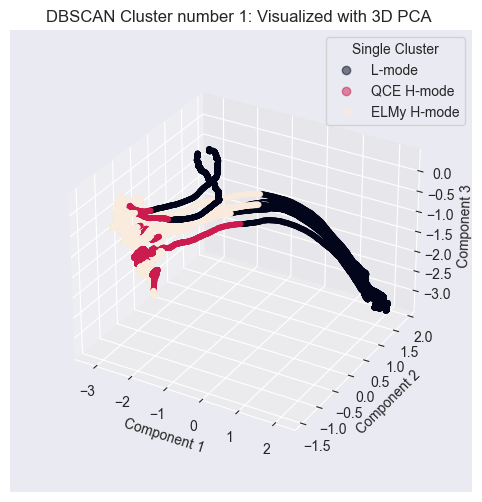

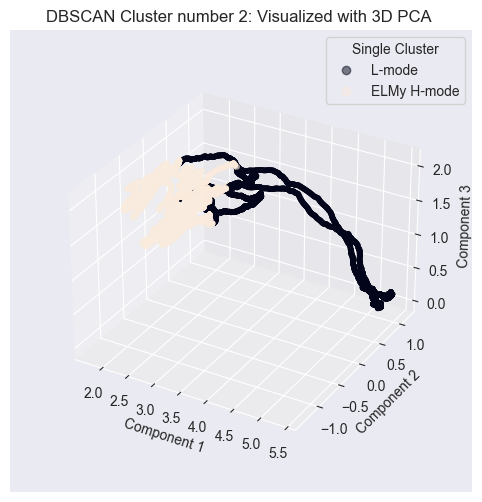

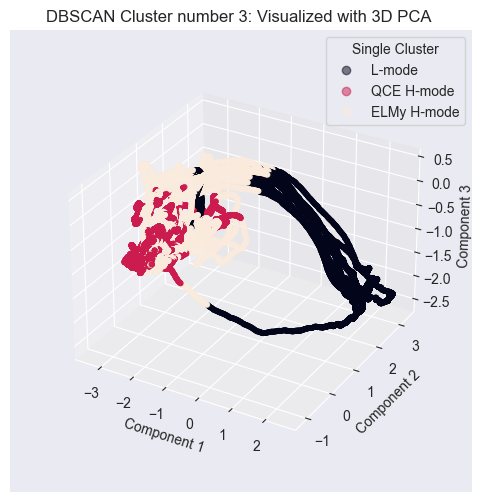

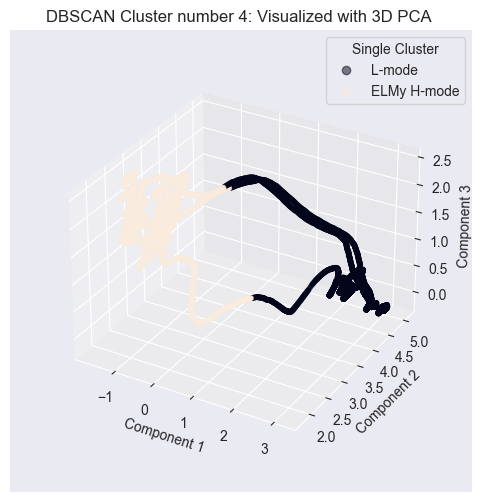

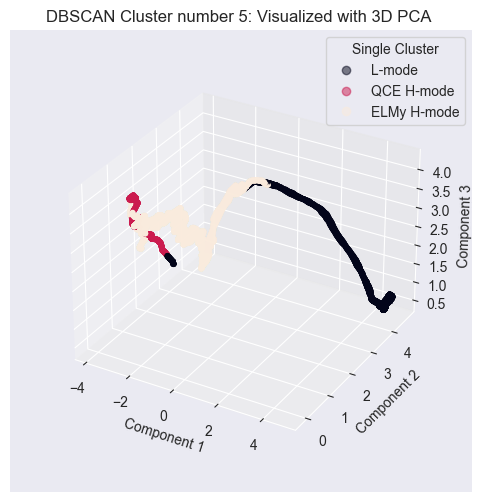

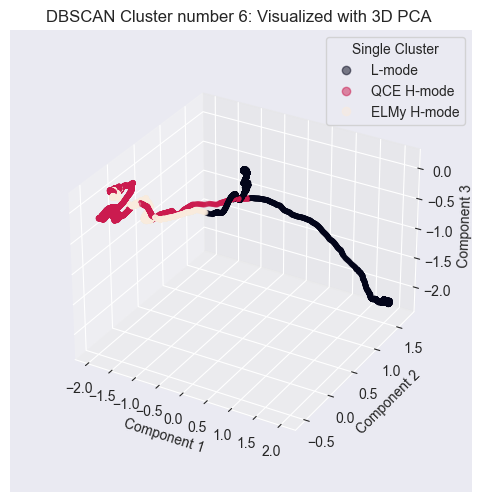

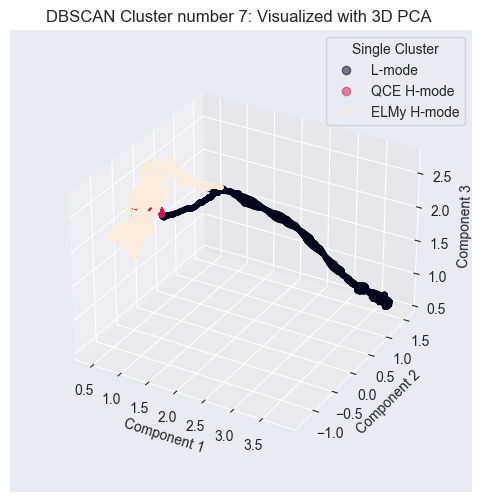

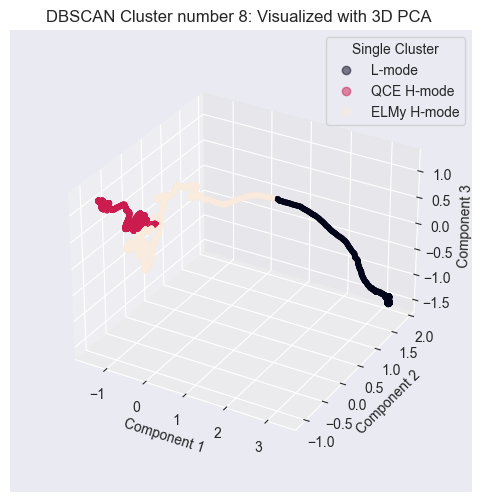

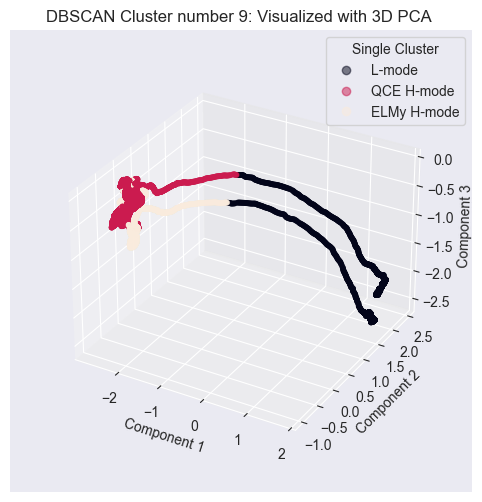

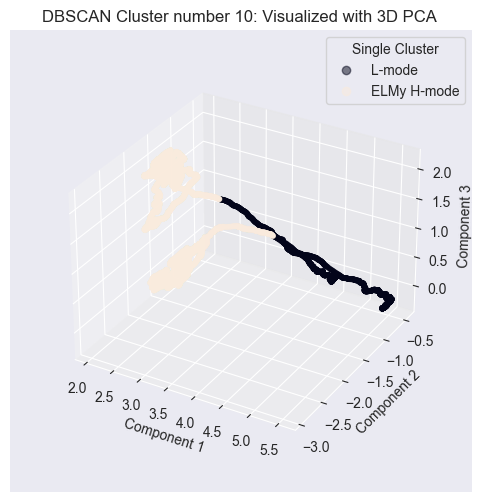

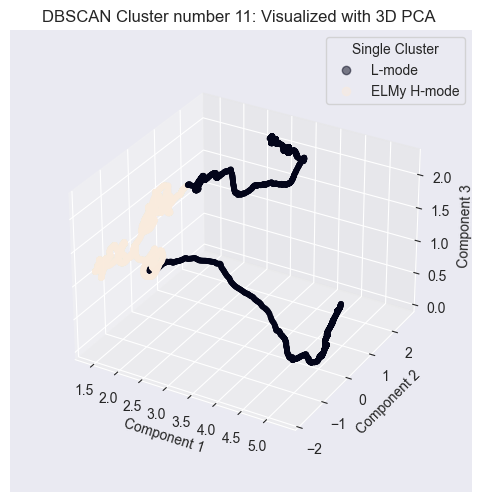

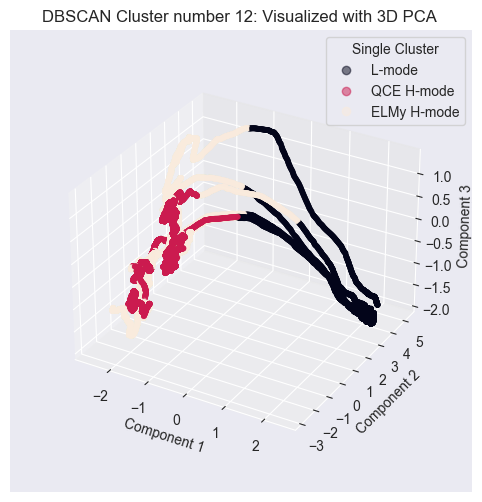

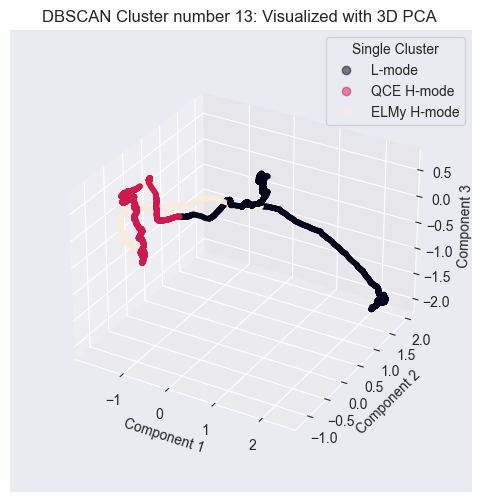

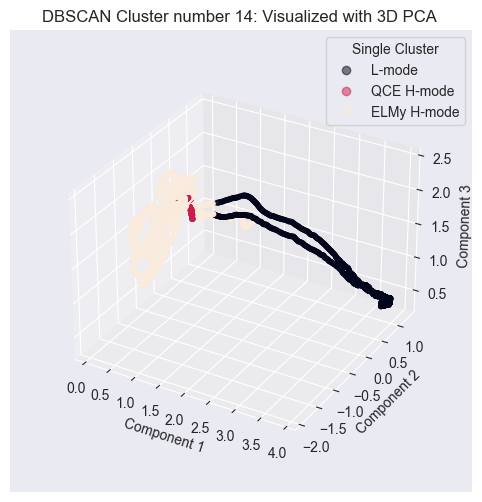

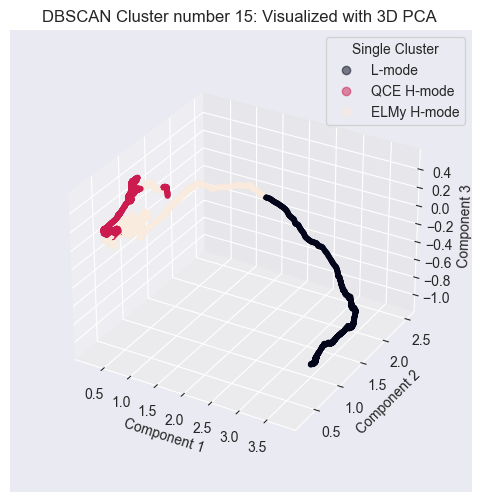

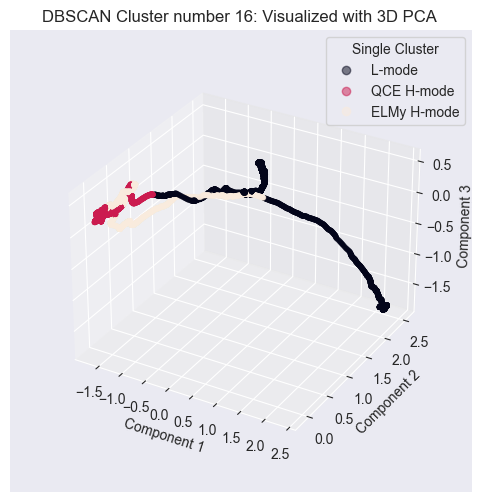

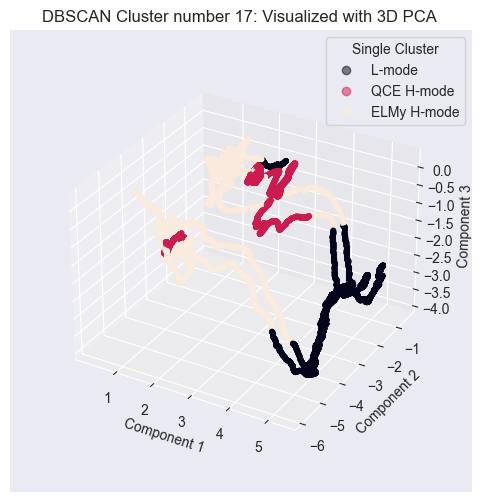

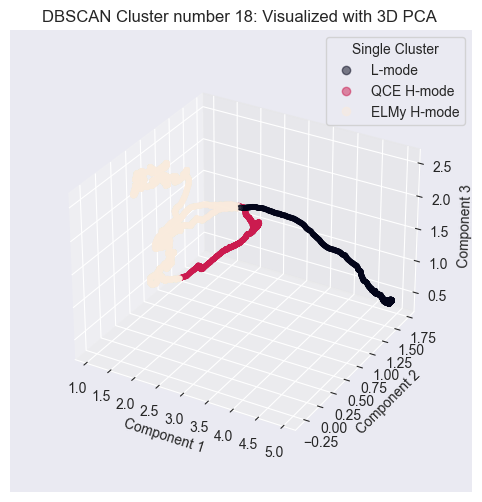

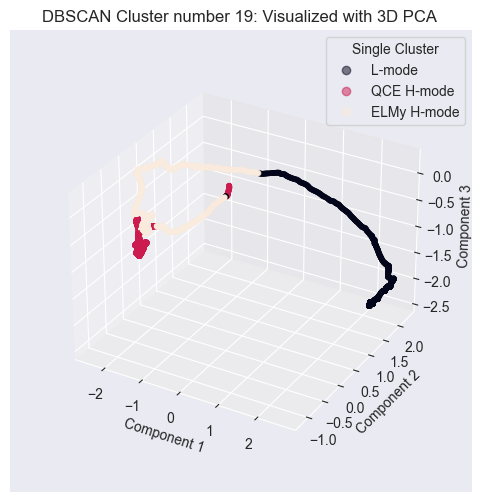

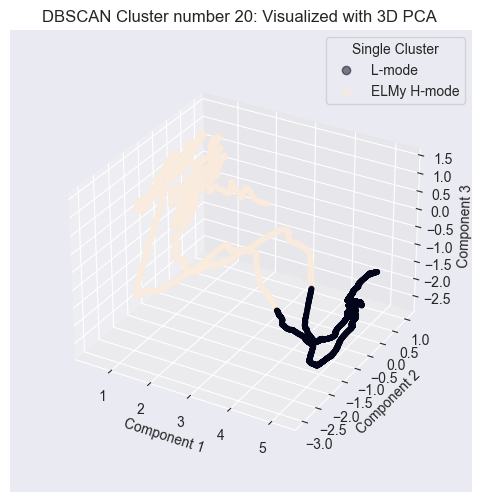

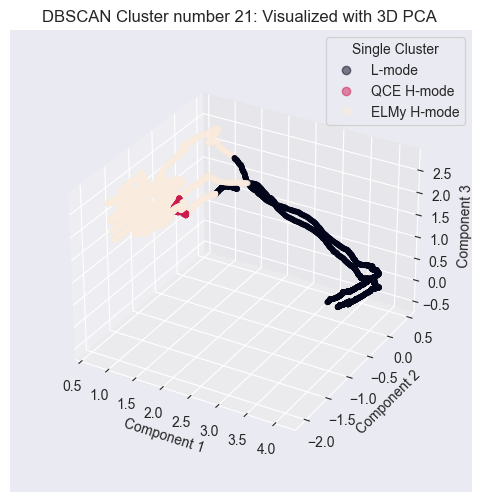

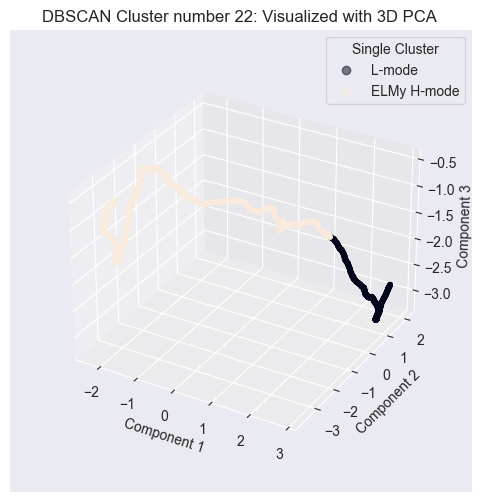

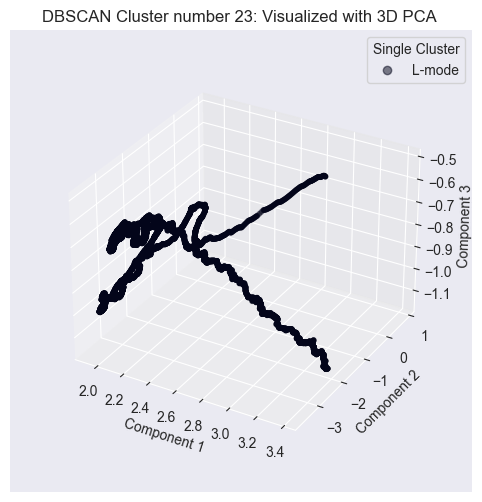

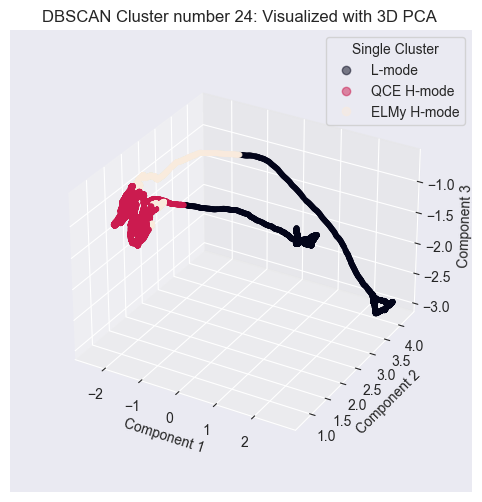

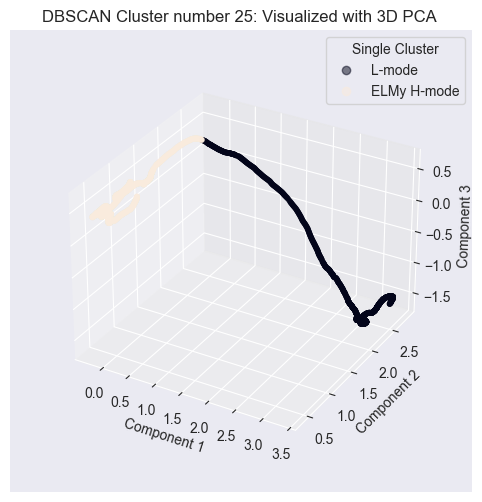

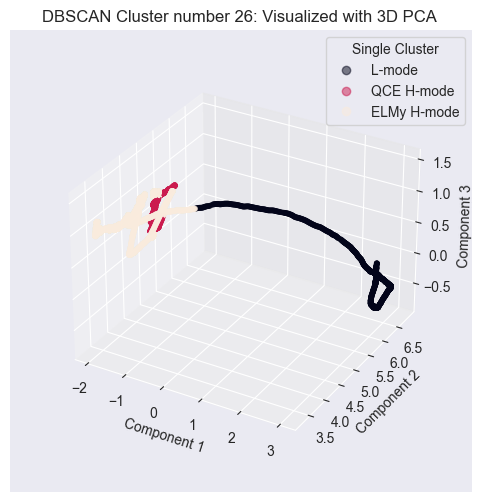

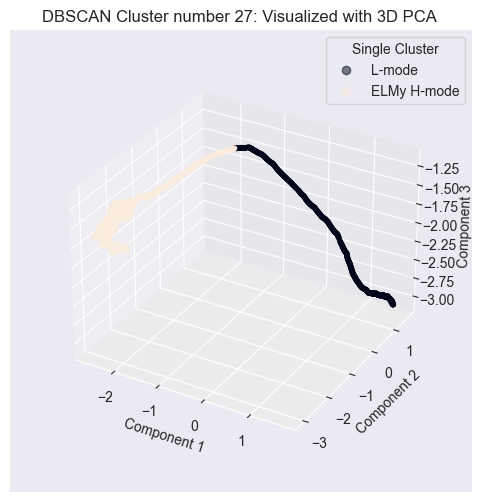

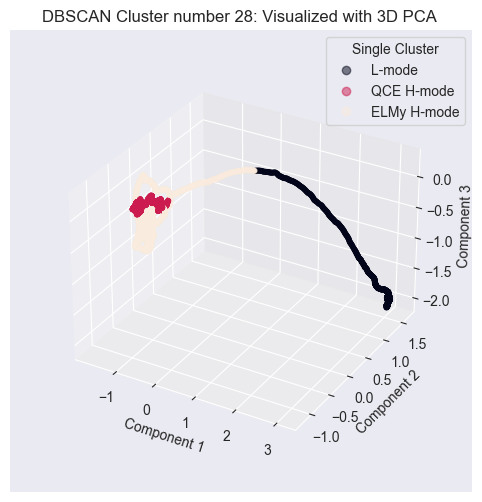

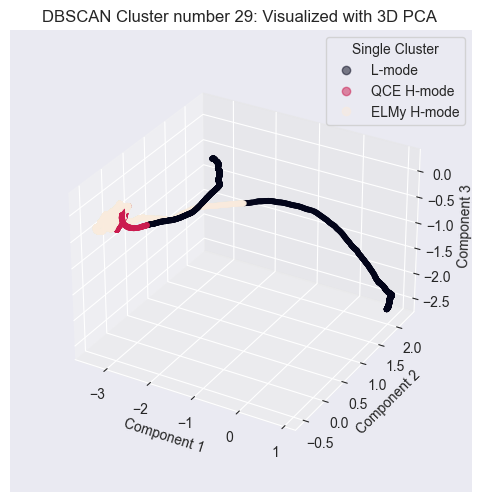

In [23]:
# Create a 3D UMAP plot for each cluster
cluster_idxs = []
for cluster_label in range(n_clusters_):
    # Filter data points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_idxs.append(cluster_indices)
    cluster_data = X_pca[cluster_indices]
    cluster_true_label = complete_y[cluster_indices]
    draw_reduced_space(cluster_data[:, :3], cluster_true_label, n_components = 3, legend_title ="Single Cluster", title = f"DBSCAN Cluster number {cluster_label + 1}: Visualized with 3D PCA ")

# Analysis

 We first notice that the DBSCAN gave us 29 clusters. as a rule of thumbs, we could argue that shots where grouped by 2. Visually, this is not the case.
 
 In clusters number 20, 21, 17, 12, 9, 4, 2 and 1 we see that the algorithm clearly managed to identify similar shots taking the same paths, attaining one the desired goal.
 
 We also notice that multiple single shots are identified such as in clusters number 25 up to 29 and shots 6, 8, 11, 13, 15, 16, 18, 19, 22 and 23. A reason to this behavior is that these shots does not have any similarity and never intersect with any of the other displayed shots/clustered shots. This allows to regroup and distinguish quite special shots.
 
Furthermore, we can also see an imbalance in mode representation in clusters : 24, 21, 20, 12, 9, 4 and 2.
Where in clusters 21, 20, 4 and 2 the QCE-H mode is clearly under-represented in favor of the two other modes, whereas in contrast clusters 24, 12 and 9 display quite clearly shots that are more in the QCE-H state. 
exploring the intra-cluster shots could allow us to understand more what is going on there.

Hence, if it is desired to compare inter-cluster shots, it is preferable to opt for DBSCAN as argued and demonstrated previously and above.

 


# Further exploration of clusters 

To detect and understand patterns, we will break down per cluster each feature repartition

First : 

**check** if single lines are truely single shots
**check** mode balancing in clusters
**understand** what allowed these shots to regroup into these various clusters

## STATISTICAL ANALYSIS

In [24]:
time_and_shot_complete_X, time_and_shot_complete_y, column_names  = get_training_data(include_time=True, 
                                           include_shotnumber=True,
                                           shot_indices=list(range(60))
                                           )
time_and_shot_complete_y_reshaped = time_and_shot_complete_y.to_numpy().reshape(-1, 1)

complete_data = np.concatenate([time_and_shot_complete_X, time_and_shot_complete_y_reshaped], axis=1)



In [25]:
# Create a DataFrame for each cluster and add them to a list
dfs = []
for i, indices in enumerate(cluster_idxs):
    df = pd.DataFrame(complete_data[indices], columns=column_names)
    df['Cluster'] = i+1
    dfs.append(df)

# Combine all the DataFrames
combined_df = pd.concat(dfs)

Check Singular and dual shots :

In [26]:
single_clustered_shots = [6, 8,11,13,15,16,18,19,22,23,25,26,27,28,29]

for i in single_clustered_shots:
    print(f"for cluster {i}, there is :{combined_df[combined_df['Cluster']==i].shotnumber.drop_duplicates().count()} shots")


for cluster 6, there is :1 shots
for cluster 8, there is :1 shots
for cluster 11, there is :1 shots
for cluster 13, there is :1 shots
for cluster 15, there is :1 shots
for cluster 16, there is :1 shots
for cluster 18, there is :1 shots
for cluster 19, there is :1 shots
for cluster 22, there is :1 shots
for cluster 23, there is :1 shots
for cluster 25, there is :1 shots
for cluster 26, there is :1 shots
for cluster 27, there is :1 shots
for cluster 28, there is :1 shots
for cluster 29, there is :1 shots


Check mode balancing in clusters :

In [27]:
labels_mapping = {1: 'L-mode', 2: 'QCE H-mode', 3: 'ELMy H-mode'}
imbalanced_clusters = [24, 21, 20, 12, 9, 4, 2]
    
for i in imbalanced_clusters:
    cluster_df = combined_df[combined_df['Cluster'] == i]
    total_count = len(cluster_df)
    print(f'Cluster {i} repartition:')
    for value, label in labels_mapping.items():
        label_count = (cluster_df['LHD_label'] == value).sum()
        print(f"\t {label}   \t: {label_count/total_count * 100: .2f}%")
    print('\n')
    


Cluster 24 repartition:
	 L-mode   	:  16.71%
	 QCE H-mode   	:  73.33%
	 ELMy H-mode   	:  9.95%


Cluster 21 repartition:
	 L-mode   	:  19.26%
	 QCE H-mode   	:  1.45%
	 ELMy H-mode   	:  79.29%


Cluster 20 repartition:
	 L-mode   	:  24.52%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  75.48%


Cluster 12 repartition:
	 L-mode   	:  15.14%
	 QCE H-mode   	:  48.69%
	 ELMy H-mode   	:  36.17%


Cluster 9 repartition:
	 L-mode   	:  16.79%
	 QCE H-mode   	:  63.26%
	 ELMy H-mode   	:  19.95%


Cluster 4 repartition:
	 L-mode   	:  48.75%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  51.25%


Cluster 2 repartition:
	 L-mode   	:  32.40%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  67.60%


Understand cluster grouping :

In [28]:
desired_clusters = list(set(range(1,29)) - set(single_clustered_shots))
interesting_clusters_df = combined_df[combined_df['Cluster'].isin(desired_clusters)].drop(columns=['time','LHD_label'])
desired_clusters

[1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 17, 20, 21, 24]

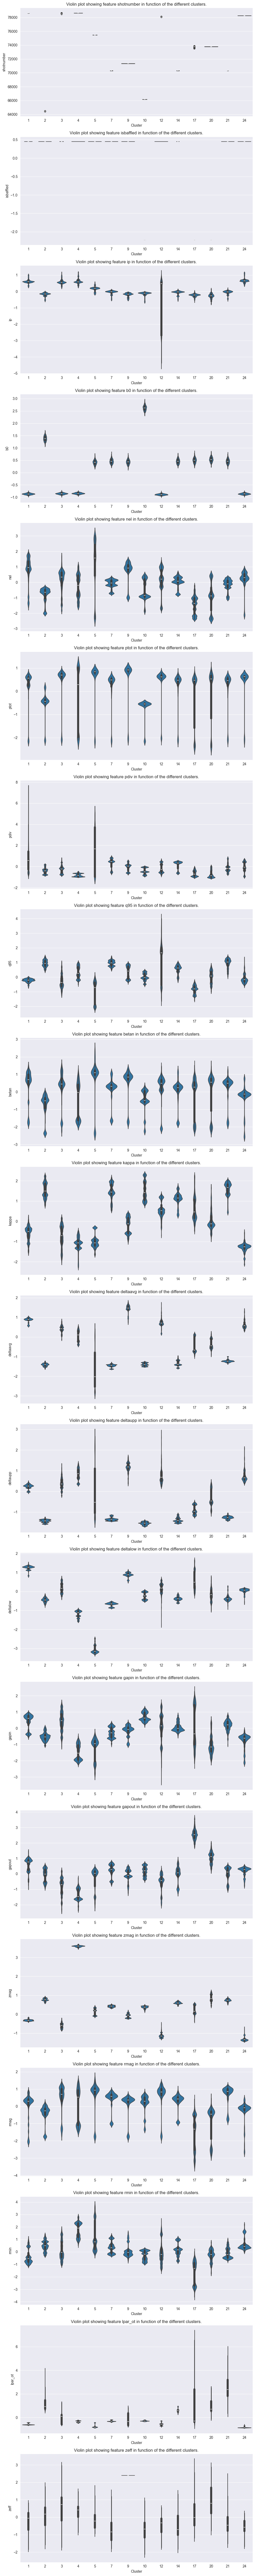

In [29]:
# Number of features to plot
num_features = interesting_clusters_df.shape[1] - 1  # excluding the cluster label column

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, figsize=(10, num_features * 5))

# Loop through each feature and create a violin plot
for i, col in enumerate(interesting_clusters_df.columns[:-1]):  # excluding the cluster label column
    sns.violinplot(x='Cluster', y=col, data=interesting_clusters_df, ax=axes[i]).set(title=f'Violin plot showing feature {col} in function of the different clusters.')

plt.tight_layout()
plt.show()


In [30]:
qce_h_clusters = [9,12,24]
non_qce_h_clusters = list(set(desired_clusters) - set(qce_h_clusters))

non_qce_h_data_points = interesting_clusters_df[interesting_clusters_df['Cluster'].isin(non_qce_h_clusters)].drop(columns=['shotnumber'])

qce_h_data_points = interesting_clusters_df[interesting_clusters_df['Cluster'].isin(qce_h_clusters)].drop(columns=['shotnumber'])

In [31]:
column_names

['shotnumber',
 'time',
 'isbaffled',
 'ip',
 'b0',
 'nel',
 'ptot',
 'pdiv',
 'q95',
 'betan',
 'kappa',
 'deltaavg',
 'deltaupp',
 'deltalow',
 'gapin',
 'gapout',
 'zmag',
 'rmag',
 'rmin',
 'lpar_ot',
 'zeff',
 'LHD_label']

In [32]:
feature_significant_difference = []
for feature in column_names[2:-1]:

    _, p_value = stats.mannwhitneyu(non_qce_h_data_points[feature], qce_h_data_points[feature])
    if p_value < 0.05:
        feature_significant_difference.append(feature)
print(f"Between non qce-h oriented clusters and qce-h oriented clusters: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(feature_significant_difference)} features: {feature_significant_difference} \n")

Between non qce-h oriented clusters and qce-h oriented clusters: Mann-Whitney U Test displays a statistical difference at 95% confidence for 18 features: ['isbaffled', 'ip', 'b0', 'nel', 'ptot', 'pdiv', 'q95', 'betan', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff'] 


# Analysis

From the above Violin plots per cluster, we can emit the hypothesis that the distinctive values of clusters are the reason shots are grouped within it:

**Cluster 4**, has a clearly distinctive `zmag` value of 3.5 for the median compared to the other clusters for a mean value between -1 and 1.

**Cluster 5**, has a  `deltalow` median value below -3 compared to the other clusters for a median value above -2.

**Cluster 9**, which exhibits many datapoints in QCE-H mode, has a uniform `zeff` of ~2.5 for the median, hence might be what distinguish it.

**Cluster 12**, has a low `zmag` below -1 for the median, as well as **Cluster 24** hence indicating some corelation towards the QCE-H state

**Cluster 17** displays the highest value of `gappout` of ~2.5 median, while most other cluster shows values below 2

Other clusters, does not exhibit direct and visible patterns. To observe them considering multiple at a time might be helpful. 
For example, as a result of clusters 12, 24 and 9, it would be valuable to verify the correlation between `zeff` and `rmag`.



However, we can also see that DBSCAN is limited in its range of data interpretation as since our analysis limited by the continuity of our data whihc does not consider **time wise history**

**For this purpose, we therefore shift in accordance with the lab to supervised learning in order to evaluate this timewise dependency thanks to either the long-short term memory neural network (LSTM) or recurrent neural network (RNN).**


# Completion purposes - Kmeans:

For completion purposes of the clustering analysis, we discuss below why the usage of the Kmean algorithm is not suited here : 

Theoretically, 
- K-means assumes that clusters are spherical and homogenous in size and variance. This assumption does not hold true for time-series data, where clusters can have different snake like shapes as seen above.
- K-means does not take into account the temporal or continuous dependencies inherent in time-series data.

In fact we can demonstrate concretely why the K-mean algorithm is not a good fit for this problem : 

In [33]:
complete_X,_, _ = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(60)))


In [34]:
%%capture
# Compute the sum of squared distances for different numbers of clusters
sse = []
for k in range(1, 11):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=0).fit(complete_X)
    sse.append(kmeans.inertia_)


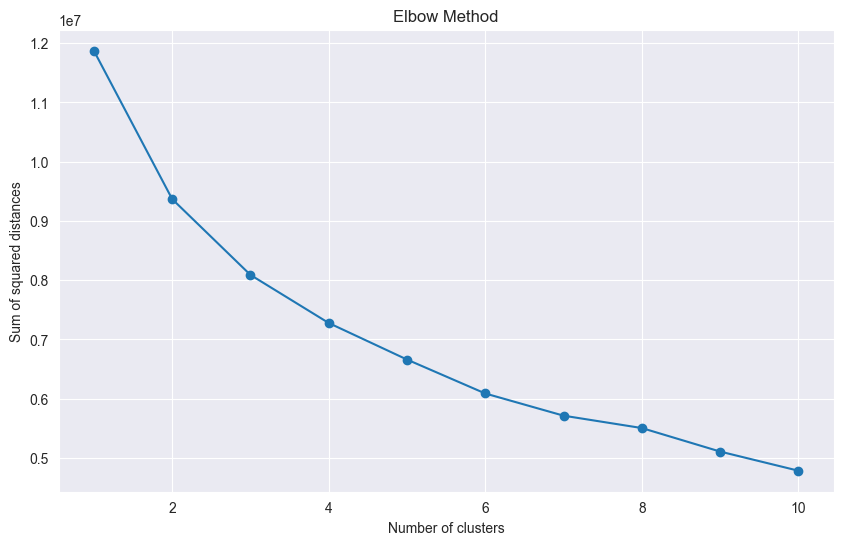

In [35]:
# Plot SSE against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')  # Adjust the range as needed
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

As the elbow is non-apparent and silhouette score takes too much time to compute, we fine tune the K parameter manually thanks to PCA visualization, this is already an indicator of limitations within the K mean analysis.

 To compare Kmeans more accurately to DBSCAN, we will use the dimensionality reduction computed above through UMAP for clustering.
 
The best K seems to be 4 according to the PCA visualization:

In [36]:
%%capture
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(complete_X)

In [37]:
pca = PCA(n_components=2)  # for 2D visualization
pca_result = pca.fit_transform(complete_X)

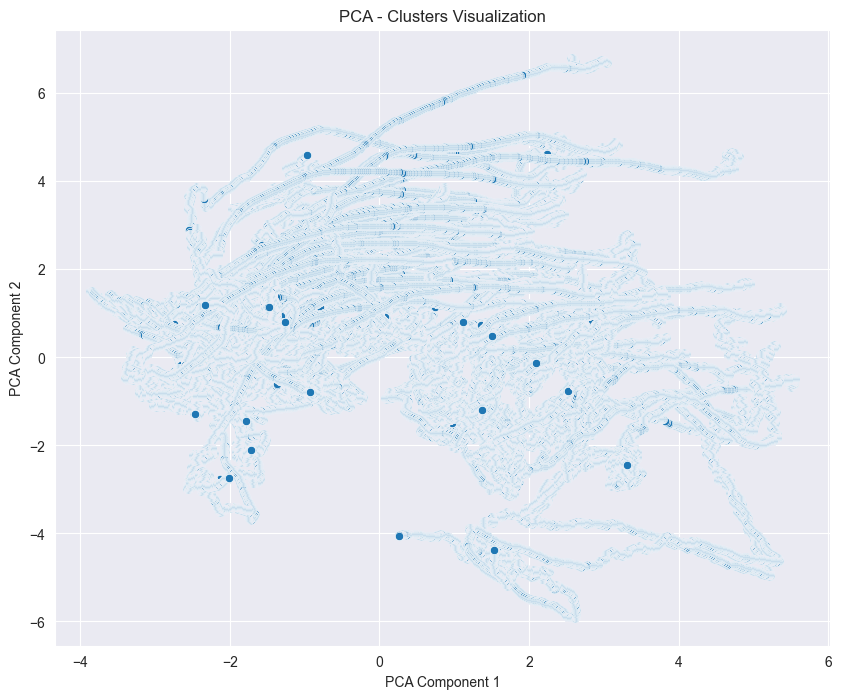

In [38]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])

plt.title('PCA - Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

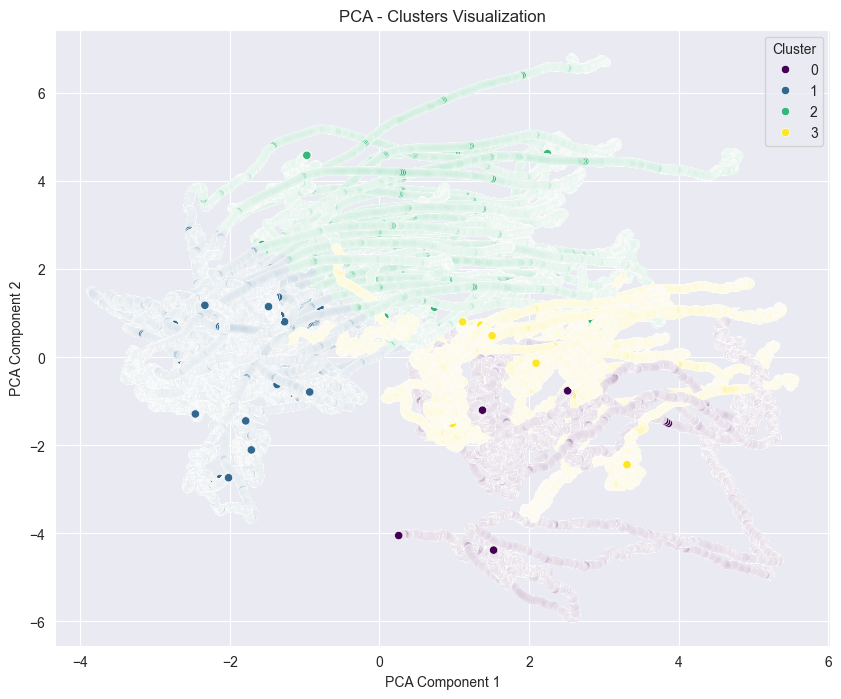

In [39]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="viridis")

plt.title('PCA - Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

The Kmeans clearly fails to map the evident clusters shown by the PCA. despite the helping UMAP, shots are not regrouped hence continuity of the data due to its timewise evolution is not considered.
This demonstrates why Kmeans is not appropriate here.


# Clustering Conclusion
Our clustering analyses were not very fruitful as we showed that our data was not adapted to Clustering. However, one interesting insight did come out of it! We saw that with DBSCAN our shots were clustered in groups. As such, we know that when training a prediction model, we must make sure that our training data represents all these clusters!

Note however that DBSCAN has one issue, it clusters shots only if they cross each other. But we want to consider shots as similar when they are almost parallel and have similar orientation! We define a distance metric between two shots. It is computed as the sum of euclidean distances between pairs of points that occured at the same timestep. As such, you may have two perfectly overlapping shots but going in opposite directions, and it will have a high distance. This is exactly what we want to achieve!

In [40]:
X, y, column_names = get_training_data(include_time = False, include_shotnumber = True, shot_indices = list(range(60)))
X.shape

(624858, 20)

We now have a normalized (important for the distance to be weighted the same for all features) array containing all the shots. And the first column corresponds to the shot numbers, so we can split X into a list of the normalized time series.

In [41]:
shot_number_col = X[:,0]
shot_number_col

array([78600., 78600., 78600., ..., 78597., 78597., 78597.])

In [42]:
shot_numbers = np.unique(shot_number_col)
shot_numbers

array([61056., 61057., 64438., 64467., 64469., 64495., 64950., 66166.,
       66169., 70302., 70305., 70306., 70310., 70311., 70313., 70654.,
       70656., 70657., 71344., 71345., 71351., 73532., 73784., 73785.,
       73786., 73838., 73846., 75461., 75464., 78058., 78061., 78064.,
       78069., 78089., 78090., 78091., 78104., 78260., 78261., 78262.,
       78368., 78382., 78510., 78512., 78518., 78521., 78524., 78597.,
       78598., 78600., 78601., 78602., 78603., 78604., 78606., 78608.,
       78611., 78637., 78639., 78656.])

In [43]:
# Split the array based on unique values in the first column
list_shots = [(shot_number, X[X[:, 0] == shot_number][:,1:]) for shot_number in shot_numbers]
len(list_shots)

60

In [44]:
list_shots[0][1].shape

(9371, 19)

In [45]:
def compute_distance_pair_shots(np_shot1, np_shot2):
    min_rows = min(np_shot1.shape[0], np_shot2.shape[0])
    
    truncated_shot1 = np_shot1[:min_rows,:]
    truncated_shot2 = np_shot2[:min_rows,:]
    
    euclidean_distance_rows = np.sqrt(np.sum((truncated_shot1 - truncated_shot2)**2, axis = 1))
    shot_distance = np.sum(euclidean_distance_rows)
    
    return shot_distance
    

In [46]:
compute_distance_pair_shots(list_shots[0][1], list_shots[4][1])

52939.38846862117

In [47]:
import itertools

shot_distances = []
for shot_number1, shot1 in list_shots:
    shot1_distances = []
    for shot_number2, shot2 in list_shots:
        shot1_distances.append(compute_distance_pair_shots(shot1, shot2))
        
    shot_distances.append(shot1_distances)
    
np_shot_distances = np.array(shot_distances)
np_shot_distances.shape

(60, 60)

In [48]:
print("max distance:", np_shot_distances.max())
print("min distance (not with itself):", np_shot_distances[np_shot_distances != 0].min())

max distance: 111195.06192942416
min distance (not with itself): 5236.837865477843


In [49]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def cluster_points(distance_matrix, threshold_distance):
    # Convert the distance matrix to condensed form
    condensed_distance = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distance, method='average')

    # Cut the dendrogram to form flat clusters based on the threshold distance
    clusters = fcluster(linkage_matrix, t=threshold_distance, criterion='distance')

    # Group point indices into clusters
    clustered_points = {}
    shot_num_to_cluster = {}
    for i, cluster_id in enumerate(clusters):
        if cluster_id not in clustered_points:
            clustered_points[cluster_id] = []
        clustered_points[cluster_id].append(shot_numbers[i-1])
        shot_num_to_cluster[shot_numbers[i-1]] = cluster_id

    return clustered_points, shot_num_to_cluster

In [50]:
threshold_distance = 50000

# Perform clustering
result_clusters, shot_num_to_cluster = cluster_points(np_shot_distances, threshold_distance)

# Display the clusters
for cluster_id, point_indices in result_clusters.items():
    print(f"Cluster {cluster_id}: {point_indices}")

Cluster 5: [78656.0, 64469.0, 64495.0, 70313.0, 70654.0, 70656.0, 70657.0, 71344.0, 71345.0, 78058.0, 78061.0, 78064.0, 78069.0, 78089.0, 78090.0, 78091.0, 78260.0, 78261.0, 78368.0, 78382.0, 78510.0, 78512.0, 78518.0, 78521.0, 78524.0, 78597.0, 78598.0, 78600.0, 78601.0, 78602.0, 78603.0, 78604.0, 78606.0, 78608.0, 78611.0, 78637.0, 78639.0]
Cluster 4: [61056.0, 61057.0, 64438.0, 64467.0, 64950.0, 66166.0, 66169.0, 70302.0, 70305.0, 70306.0, 70310.0, 70311.0]
Cluster 3: [71351.0, 73532.0, 73784.0, 73785.0, 73786.0, 73838.0]
Cluster 1: [73846.0, 75461.0]
Cluster 6: [75464.0]
Cluster 2: [78104.0]
Cluster 7: [78262.0]


Now we want to visualize these clusters! So we need to map the shot_numbers to the associated clusters

In [51]:
cluster_labels = np.copy(shot_number_col)
for k, v in shot_num_to_cluster.items(): 
    cluster_labels[cluster_labels==k] = v
cluster_labels

array([5., 5., 5., ..., 5., 5., 5.])

In [52]:
components = perform_pca(X[:,1:], n_components = 3) # we discard the shotnumber

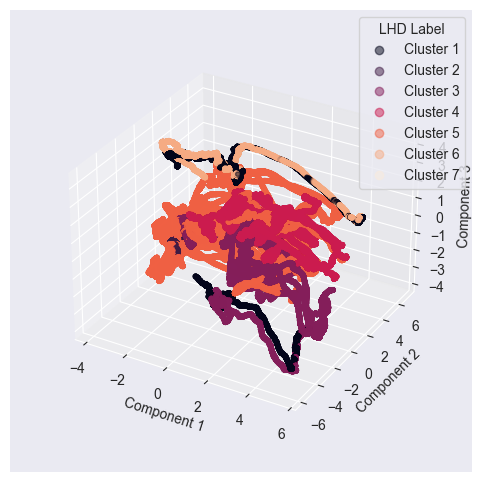

In [53]:
cluster_names = [f"Cluster {i+1}" for i in range(len(result_clusters))]
draw_reduced_space(components, cluster_labels, n_components=3, legend_labels = cluster_names, legend_title = "LHD Label", title='')